# Field inference for multiple dipole sources

We have shown (`potentials.ipynb`) that it is possible to learn analytical forms like the dipole field with acceptable accuracy through a variety of routes including the scalar and vector potentials. In this demonstration, we want to model the potential/field from multiple fixed sources at arbitrary field points, and to do so while running over the sources and inference points separately; i.e. O(M + N) and not O(M * N).

We suppose this to be possible because of the principle of superposition for potentials / fields, and our implementation separately the input of magnetic sources (the 'priming' network) from the inference ('main' network). In particular, we try learning a hypernetwork where the role of the priming network is to output the weights for the main network. We will use jax, equinox and optax to develop a model combining neural and analytical (autodiff) components.

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt


## I. Target definition and data augmentation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{4\pi |\mathbf{r}-\mathbf{r_i}|^2}}^{\text{Surface of 3D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have the more general form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. Similarly, the potential in two dimensions is obtained by exchanging the surface area of the 2D ball.

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [2]:
def scalar_potential(m, r0, r):
    core = 0.5
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm < core
    interior = m_dot_r / core / (2 * jnp.pi * core)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)


def generate_total_potential(m, r0, r):
    points = jax.vmap(scalar_potential, in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return jnp.sum(potential, axis=0)


def generate_total_field(m, r0, r):
    points = jax.vmap(jax.grad(scalar_potential, argnums=2), in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return -jnp.sum(potential, axis=0)


In [3]:
def plots(x_grid, y_grid, potential, field, idx=0):
    fig = plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Magnetic Scalar Potential
    cp = axes[0].contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    axes[0].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[0].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[0].set_title("Magnetic Scalar Potential")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Subplot 2: Magnetic Field
    axes[1].streamplot(
        x_grid,
        y_grid,
        field[idx, :, :, 0],
        field[idx, :, :, 1],
        density=1.5,
        linewidth=1,
        arrowsize=1.5,
        arrowstyle="->",
    )
    axes[1].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[1].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[1].set_title("Magnetic Field")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()


In [4]:
M = 4
N = 1
key, subkey = jr.split(jr.PRNGKey(342 - 1), 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)


In [5]:
lim, res = 3, 50
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total_potential(m, r0, flat_grid)
field = generate_total_field(m, r0, flat_grid)


<Figure size 640x480 with 0 Axes>

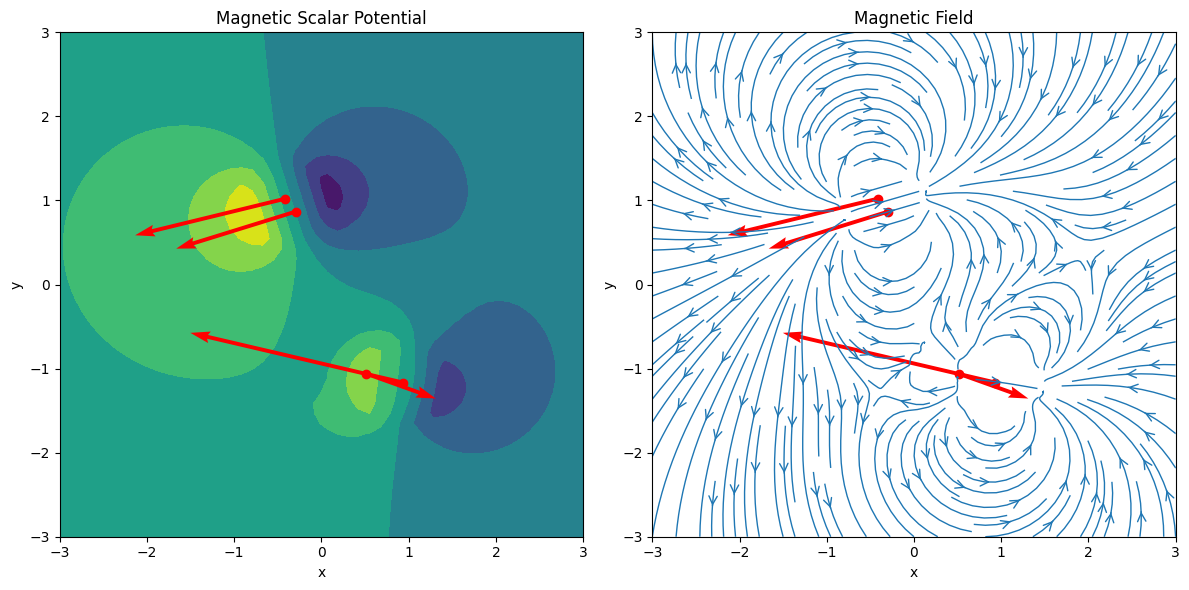

In [6]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=0,
)


## II. Inference

To start with, let's show that we can model the potential for this static source configuration, generalising to new field points without making any attempt at learning how the sources influence it. The grid points and evaluations we've used for plotting above are ready to be used as training data. We train an MLP network of fixed size to learn $\mu_0 \mathbf{H}$, using the relative geometric error as the target measure of accuracy. 

In [7]:
key, subkey = jr.split(key, 2)

model = eqx.nn.MLP(
    in_size=2,
    out_size="scalar",
    width_size=32,
    depth=3,
    activation=jax.nn.gelu,
    use_bias=True,
    use_final_bias=False,
    key=subkey,
)

@eqx.filter_jit
def loss(model, r, target):
    pred = jax.vmap(model)(r)
    return jnp.mean(optax.huber_loss(pred, target))

@eqx.filter_jit
def accuracy(model, r, target):
    pred = jax.vmap(model)(r)
    diff = jnp.linalg.norm(target - pred)
    return diff / jnp.linalg.norm(target) * 100


In [8]:
print(loss(model, flat_grid, potential))


0.036084034


The training loop for the model, using the Adam optimiser and using batch (i.e. full batch) training, and logging the accuracy 100 times during the run of 10,000 epochs.

In [9]:
@eqx.filter_jit
def train_step(model, opt_state, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkey, size=10_000):
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(size, 2), key=subkey)
    potential = generate_total_potential(m, r0, mesh)
    return jnp.median(accuracy(model, mesh, potential))


optim = optax.adam(learning_rate=0.01)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 10_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    model, opt_state, train_loss = train_step(model, opt_state, flat_grid, potential)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(jnp.median(accuracy(model, flat_grid, potential)))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        logger["val_acc"].append(validation_set(model, subkey))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge = validation_set(model, subkey)
print(f"Final accuracy: {rge:.2f}%")


step=0, train_loss=0.0361,  accuracy=75.0466 val_accuracy=75.2651
step=1000, train_loss=0.0001,  accuracy=4.1155 val_accuracy=4.1997
step=2000, train_loss=0.0000,  accuracy=2.2016 val_accuracy=2.2181
step=3000, train_loss=0.0000,  accuracy=2.0200 val_accuracy=1.9507
step=4000, train_loss=0.0000,  accuracy=1.4627 val_accuracy=1.4726
step=5000, train_loss=0.0000,  accuracy=1.2387 val_accuracy=1.2765
step=6000, train_loss=0.0000,  accuracy=1.0647 val_accuracy=1.1647
step=7000, train_loss=0.0000,  accuracy=0.9157 val_accuracy=1.0459
step=8000, train_loss=0.0000,  accuracy=0.8924 val_accuracy=1.0392
step=9000, train_loss=0.0000,  accuracy=0.8614 val_accuracy=1.0290
Final accuracy: 2.06%


In [10]:
# generate random points within the limits
pred_potential = jax.vmap(model)(flat_grid)
pred_field = -jax.vmap(jax.grad(model))(flat_grid)


<Figure size 640x480 with 0 Axes>

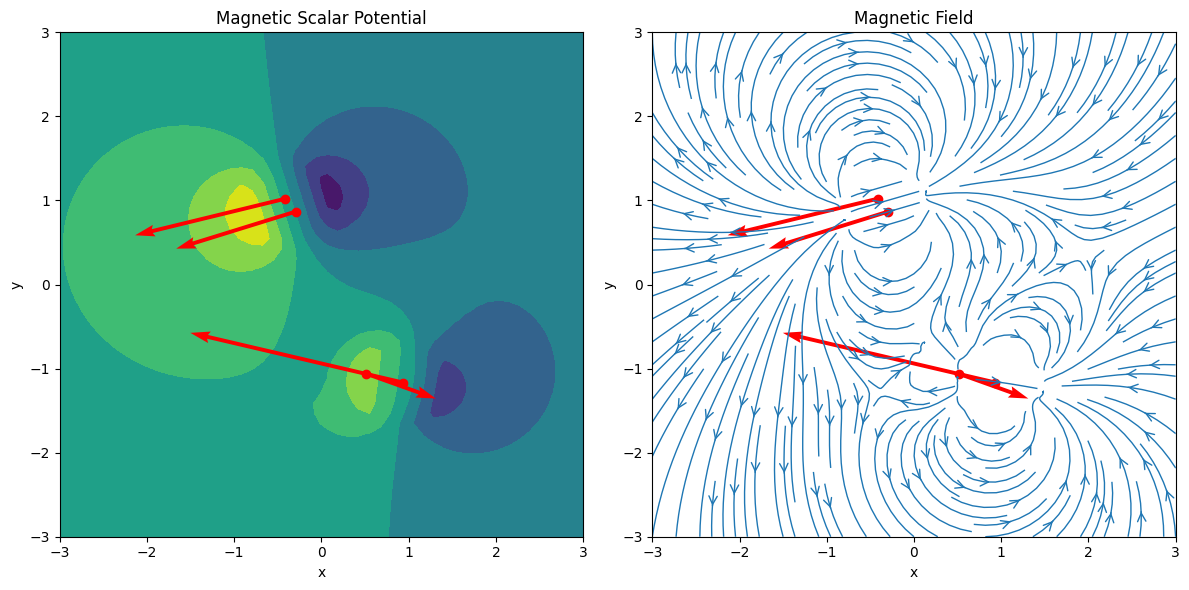

<Figure size 640x480 with 0 Axes>

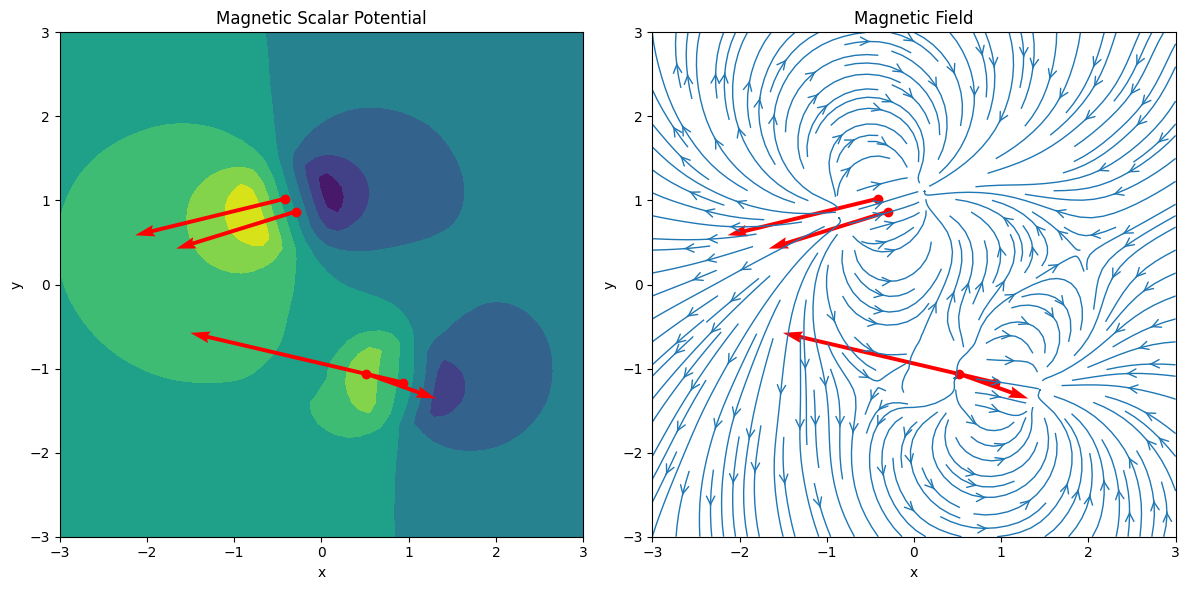

In [11]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
)

plots(
    x_grid,
    y_grid,
    pred_potential.reshape(1, res, res),
    pred_field.reshape(N, res, res, 2),
)


## III. Learning the dependence on magnetic moment

An MLP can evidently generalise to unseen random field point locations. But can we understand how the weights of the MLP depend on the magnetic sources? To attempt this, we create a second ('hyper'-)network, whose purpose is to receive the collection of sources and output *the weights* of the ('main') inference network. 

In [18]:
N, M = 1000, 3
key, subkey = jr.split(jr.PRNGKey(2342), 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)


In [19]:
lim, res = 3, 50
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total_potential(m, r0, flat_grid)
field = generate_total_field(m, r0, flat_grid)


<Figure size 640x480 with 0 Axes>

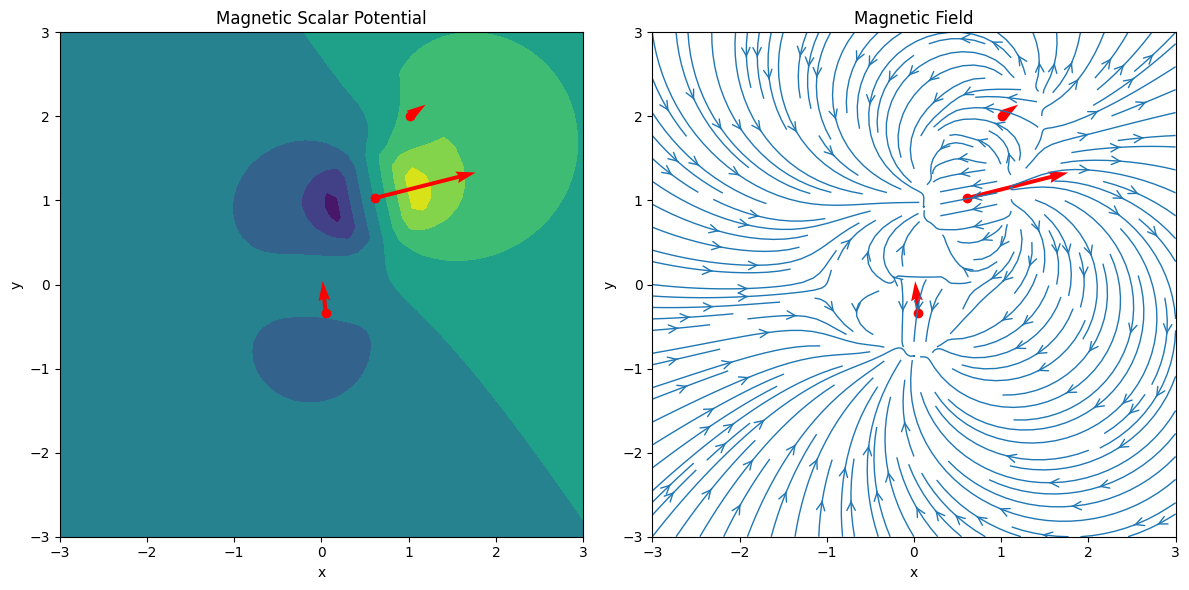

In [20]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=5,
)


In [21]:
def is_linear(x):
    return isinstance(x, eqx.nn.Linear)


def get_weights(model):
    leaves = jax.tree_util.tree_leaves(model, is_leaf=is_linear)
    return [x.weight for x in leaves if is_linear(x)]


def get_biases(model):
    leaves = jax.tree_util.tree_leaves(model, is_leaf=is_linear)
    return [x.bias for x in leaves if is_linear(x)]


@jax.jit
def reshape_params(old_params, params):
    new_params = []
    for w in old_params:
        new_params.append(jnp.reshape(params[: w.size], w.shape))
        params = params[w.size :]
    return new_params


class HyperModel(eqx.Module):
    rho: eqx.nn.MLP
    nbiases: int
    nweights: int
    model: eqx.nn.MLP = eqx.field(static=True)

    def __init__(self, width, depth, hyperkey, mainkey):
        self.model = eqx.nn.MLP(
            2, "scalar", width, depth, jax.nn.gelu, use_bias=True, key=mainkey
        )
        self.nweights = sum(w.size for w in get_weights(self.model))
        self.nbiases = sum(b.size for b in get_biases(self.model))
        nparams = self.nweights + self.nbiases
        self.rho = eqx.nn.MLP(4, nparams, nparams, 2, jax.nn.gelu, key=hyperkey)
    
    def prepare_weights(self, m_r):
        wb = jnp.sum(jax.vmap(self.rho)(m_r), axis=0)
        weights, biases = wb[: self.nweights], wb[self.nweights :]
        return weights, biases
    
    def prepare_model(self, weights, biases):
        model = eqx.tree_at(
            get_weights, self.model, reshape_params(get_weights(self.model), weights)
        )
        model = eqx.tree_at(
            get_biases, model, reshape_params(get_biases(model), biases)
        )
        return model
    
    def field(self, m_r, r):
        weights, biases = self.prepare_weights(m_r)
        model = self.prepare_model(weights, biases)
        return -jax.vmap(jax.grad(model))(r)

    def __call__(self, m_r, r):
        weights, biases = self.prepare_weights(m_r)
        model = self.prepare_model(weights, biases)
        return jax.vmap(model)(r)


key, hyperkey, mainkey = jr.split(key, 3)
hypermodel = HyperModel(16, 3, hyperkey, mainkey)


In [22]:
@eqx.filter_jit
def loss(model, m_r, r, target):
    pred = jax.vmap(model, in_axes=(0, None))(m_r, r)
    return jnp.mean(optax.huber_loss(pred, target)) 


@eqx.filter_jit
def accuracy(model, m_r, r, target):
    pred = jax.vmap(model, in_axes=(0, None))(m_r, r)
    diff = jnp.linalg.norm(target - pred)
    return diff / jnp.linalg.norm(target) * 100


m_r = jnp.concatenate([m, r0], axis=-1)
# print(m.shape, r0.shape, flat_grid.shape, potential.shape)
print(loss(hypermodel, m_r, flat_grid, potential))
print(accuracy(hypermodel, m_r, flat_grid, potential))


0.039681613
171.2933


In [23]:
m_r = jnp.concatenate([m, r0], axis=-1)


@eqx.filter_jit
def train_step(model, opt_state, m_r, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, m_r, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkeys):
    m, r0 = jnp.split(jr.normal(key=subkeys.pop(), shape=(N, M, 4)), 2, axis=-1)
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkeys.pop())
    # mesh = flat_grid
    potential = generate_total_potential(m, r0, mesh)
    m_r = jnp.concatenate([m, r0], axis=-1)
    return jnp.median(accuracy(model, m_r, mesh, potential))


optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(eqx.filter(hypermodel, eqx.is_array))
steps = 1_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    hypermodel, opt_state, train_loss = train_step(
        hypermodel, opt_state, m_r, flat_grid, potential
    )
    if (step % (steps / 100)) == 0:
        key, *subkeys = jr.split(key, 3)
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(accuracy(hypermodel, m_r, flat_grid, potential))
        logger["val_acc"].append(validation_set(hypermodel, subkeys))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )


step=0, train_loss=0.0397,  accuracy=1234.0565 val_accuracy=1205.3724
step=100, train_loss=0.0072,  accuracy=70.1512 val_accuracy=71.7364
step=200, train_loss=0.0043,  accuracy=55.1785 val_accuracy=58.5486
step=300, train_loss=0.0034,  accuracy=50.0509 val_accuracy=55.2872
step=400, train_loss=0.0037,  accuracy=57.8685 val_accuracy=62.2780
step=500, train_loss=0.0026,  accuracy=43.5499 val_accuracy=49.5850
step=600, train_loss=0.0035,  accuracy=46.1137 val_accuracy=52.9575
step=700, train_loss=0.0022,  accuracy=39.5131 val_accuracy=48.5185
step=800, train_loss=0.0018,  accuracy=36.5631 val_accuracy=47.9580
step=900, train_loss=0.0017,  accuracy=35.5776 val_accuracy=49.8061


In [27]:
def plotsv(x_grid, y_grid, m, r0, potential, field=None, idx=0):
    fig = plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Magnetic Scalar Potential
    cp = axes[0].contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    axes[0].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[0].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[0].set_title("Magnetic Scalar Potential")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Subplot 2: Magnetic Field
    if field is not None:
        axes[1].streamplot(
            x_grid,
            y_grid,
            field[idx, :, :, 0],
            field[idx, :, :, 1],
            density=1.5,
            linewidth=1,
            arrowsize=1.5,
            arrowstyle="->",
        )
        axes[1].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
        axes[1].quiver(
            r0[idx, :, 0],
            r0[idx, :, 1],
            m[idx, :, 0],
            m[idx, :, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="red",
        )
        axes[1].set_title("Magnetic Field")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

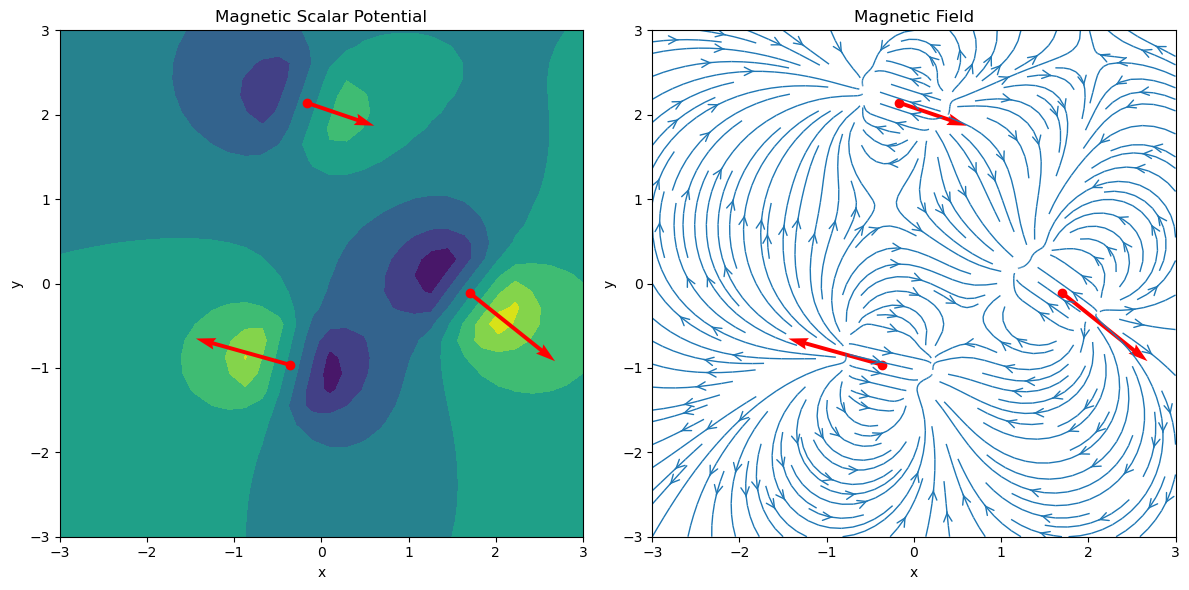

<Figure size 640x480 with 0 Axes>

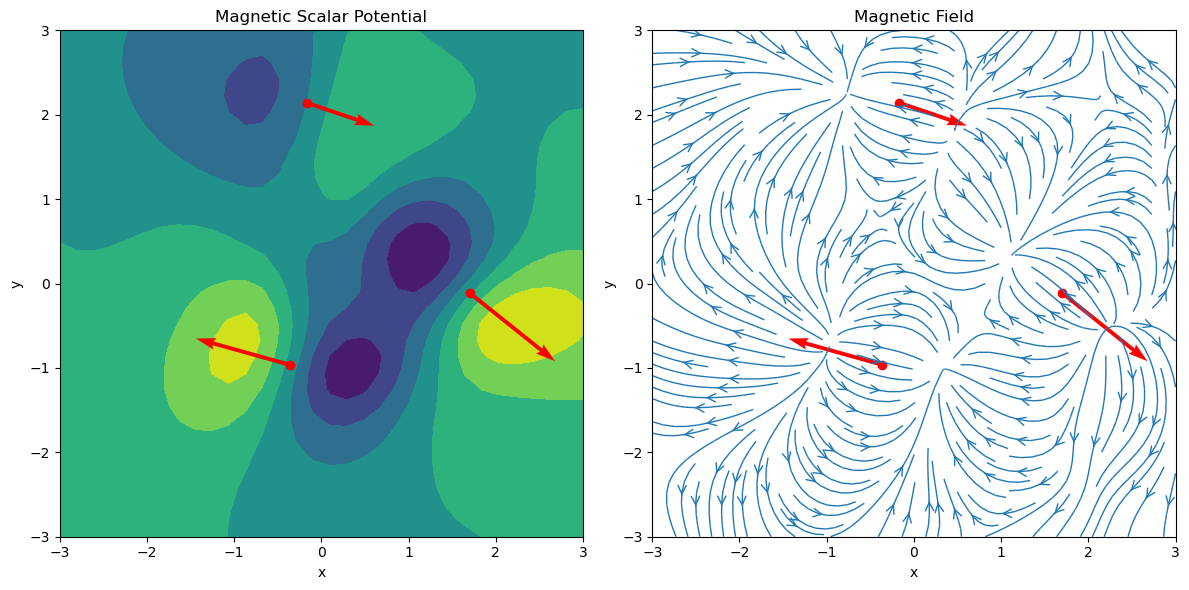

In [28]:
pred_potential = jax.vmap(hypermodel, in_axes=(0, None))(m_r, flat_grid)
pred_field = jax.vmap(hypermodel.field, in_axes=(0, None))(m_r, flat_grid)
plotsv(
    x_grid,
    y_grid,
    m,
    r0,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
)
plotsv(
    x_grid,
    y_grid,
    m,
    r0,
    pred_potential.reshape(N, res, res),
    pred_field.reshape(N, res, res, 2),
)


<Figure size 640x480 with 0 Axes>

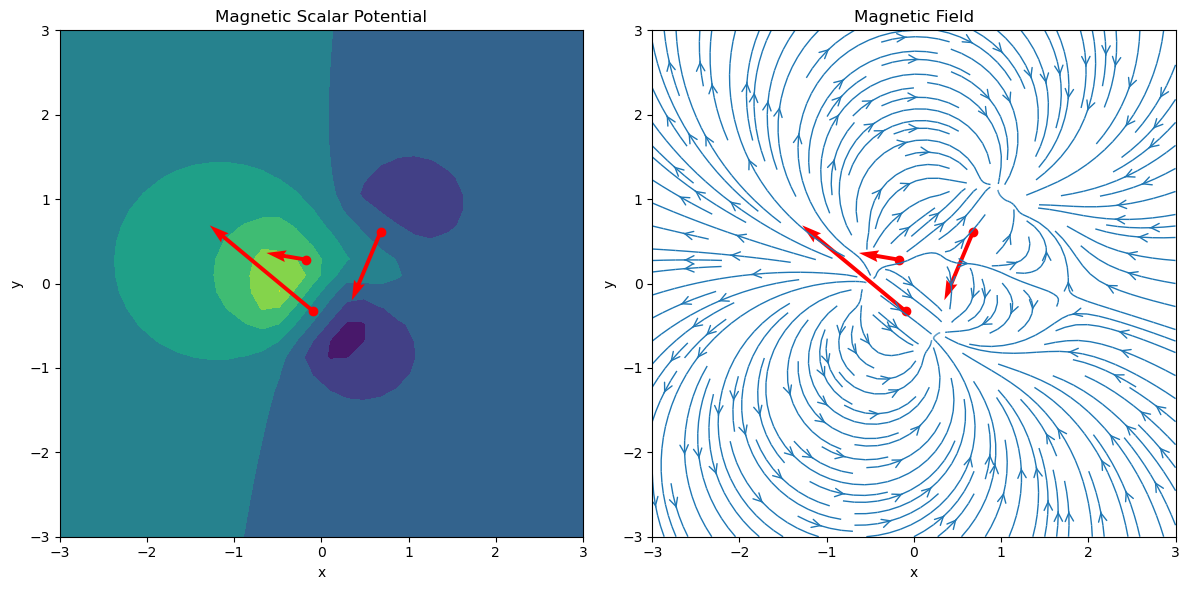

<Figure size 640x480 with 0 Axes>

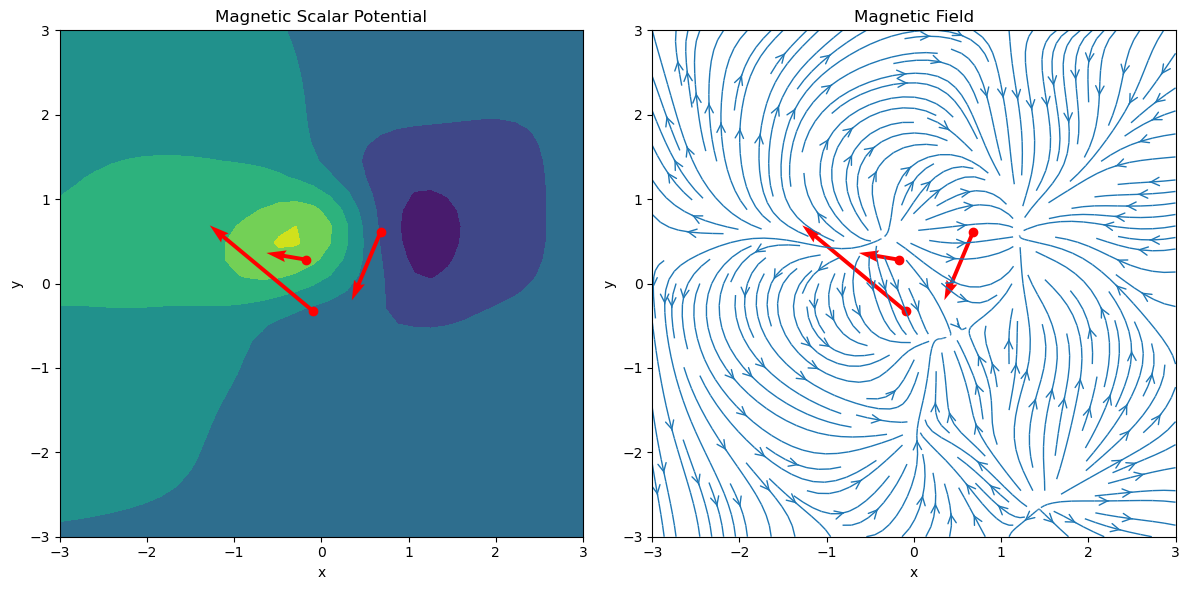

In [30]:
Nv, Mv = 1, 3
key, subkey = jr.split(jr.PRNGKey(3563 + 1), 2)
mr_v = jr.normal(key=subkey, shape=(Nv, Mv, 4))
mv, r0v = jnp.split(mr_v, 2, axis=-1)

val_potential = generate_total_potential(mv, r0v, flat_grid)
val_field = generate_total_field(mv, r0v, flat_grid)

pred_potential = jax.vmap(hypermodel, in_axes=(0, None))(mr_v, flat_grid)
pred_field = jax.vmap(hypermodel.field, in_axes=(0, None))(mr_v, flat_grid)

plotsv(
    x_grid,
    y_grid,
    mv,
    r0v,
    val_potential.reshape(Nv, res, res),
    val_field.reshape(Nv, res, res, 2),
)
plotsv(
    x_grid,
    y_grid,
    mv,
    r0v,
    pred_potential.reshape(Nv, res, res),
    pred_field.reshape(Nv, res, res, 2),
)
